# Goodreads dataset

[Link](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home?) to the dataset.

The datasets were collected in late 2017 from [goodreads.com](https://www.goodreads.com/). User IDs and review IDs are anonymized.

This dataset consists of three tables:
- **goodreads_books**. Book descriptions: authors, ISBN, title, page number, etc.
- **goodreads_books_authors**. Book authors: names, ratings.
- **goodreads_books_works**. Book profile (book description regardless of edition, ISBN: title, rating, year of publication, etc.)
- **goodreads_books_series**. Book series: title, description, number of books in series.
- **goodreads_interactions**, **user_id_map**, **book_id_map**. User ratings.

The data are freely available for research use when acknowledged with the references:
- [«Item Recommendation on Monotonic Behavior Chains»](https://dblp.uni-trier.de/rec/conf/recsys/WanM18.html?view=bibtex)
- [«Fine-Grained Spoiler Detection from Large-Scale Review Corpora»](https://dblp.uni-trier.de/rec/conf/acl/WanMNM19.html?view=bibtex)

After downloading, the data was saved in the [data original folder](data_original).

In [1]:
import os
import sys

# Append the sys.path with the project root path
sys.path.append(os.path.dirname(os.path.abspath('')))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from isbnlib import is_isbn10, is_isbn13

from utils.preprocessing import convert_to_isbn13, get_weighted_rating, \
    normalize_language_code

# To print many columns
pd.set_option('display.max_columns', 100)

# To print many rows
pd.set_option('display.max_rows', 100)

# To wrap long values
pd.set_option('display.max_colwidth', 50)

# To use seaborn style for plots
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_context('talk')
sns_palette = sns.color_palette(plt.cm.get_cmap('tab20c').colors)

##  Books

In accordance to the data description, the `goodreads_books` dataset contains the following columns:

- `book_id`: book identifier
- `work_id`: id of book profile
- `isbn`: ISBN 
- `isbn13`: ISBN-13
- `asin`: Amazon identifier
- `kindle_asin`: book identifier on Amazon for Kindle
- `title`: book title
- `title_without_series`: book title without series
- `series`: series name
- `description`: book description
- `authors`: authors ids
- `publisher`: publisher
- `num_pages`: number of pages in the book
- `publication_day`: publication day
- `publication_month`: publication month
- `publication_year`: publication year
- `edition_information`: information about edition
- `country_code`: country code
- `language_code`: language
- `is_ebook`: is this book electronic
- `format`: book format (paperback, etc.)
- `similar_books`: list of books which is liked by those who likes this
- `popular_shelves`: saved lists where this book was included
- `ratings_count`: number of ratings
- `text_reviews_count`: number of text reviews
- `average_rating`: average book rating
- `link`: book link on goodreads.com
- `url`: another book link on goodreads.com
- `image_url`: link to book image

Here, we will not analyze ratings, because there is more informative dataset of ratings. We also will not use `asin`, `kindle_asin`, `publication_day`, `publication_month`,
`popular_shelves`, `similar_books`, `link`, `url`.

The description of the columns in the dataset allows us to discard unnecessary parameters, and to specify the column data type to reduce the amount of memory used:

In [3]:
book_cols = [
    'book_id', 'work_id', 'isbn', 'isbn13', 'title',
    'title_without_series', 'series', 'description',
    'publisher', 'num_pages', 'authors', 'image_url',
    'publication_year', 'edition_information',
    'language_code', 'is_ebook', 'format', 'country_code',
    'ratings_count'  # these ratings only for the section 'Works'
]

book_dtypes = {
    'book_id': 'str', 'work_id': 'str', 'isbn': 'str', 'isbn13': 'str',
    'title': 'str', 'title_without_series': 'str', 'description': 'str',
    'publisher': 'str', 'num_pages': 'float32', 'image_url': 'str',
    'publication_year': 'float32', 'edition_information': 'str',
    'country_code': 'category', 'language_code': 'category',
    'format': 'category', 'is_ebook': 'object',
    'ratings_count': 'float32'
}

book_converters = {'authors': eval, 'series': eval}
path_books = os.path.join('data_original', 'goodreads_books.json.csv')
books = pd.read_csv(path_books, usecols=book_cols,
                    dtype=book_dtypes, converters=book_converters)

In [4]:
books.head(5)

,isbn,series,country_code,language_code,is_ebook,description,format,authors,publisher,num_pages,isbn13,edition_information,publication_year,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,[],US,NaN,false,NaN,Paperback,"[{'author_id': '604031', 'role': ''}]",St. Martin's Press,256.0,9780312853129,NaN,1984.0,https://images.gr-assets.com/books/1310220028m...,5333265,3.0,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,[],US,NaN,false,"Anita Diamant's international bestseller ""The ...",Audio CD,"[{'author_id': '626222', 'role': ''}]",Simon & Schuster Audio,NaN,9780743509985,Abridged,2001.0,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10.0,1323437,Good Harbor,Good Harbor
2,NaN,[189911],US,eng,false,Omnibus book club edition containing the Ladie...,Hardcover,"[{'author_id': '10333', 'role': ''}]","Nelson Doubleday, Inc.",600.0,NaN,Book Club Edition,1987.0,https://images.gr-assets.com/books/1304100136m...,7327624,140.0,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,[],US,eng,false,Addie Downs and Valerie Adler were eight when ...,Hardcover,"[{'author_id': '9212', 'role': ''}]",Atria Books,368.0,9780743294294,NaN,2009.0,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184.0,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,[],US,NaN,false,NaN,NaN,"[{'author_id': '149918', 'role': ''}]",NaN,NaN,9780850308716,NaN,NaN,https://images.gr-assets.com/books/1413219371m...,287140,15.0,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...


In [5]:
books.iloc[0]

isbn                                                           0312853122
series                                                                 []
country_code                                                           US
language_code                                                         NaN
is_ebook                                                            false
description                                                           NaN
format                                                          Paperback
authors                             [{'author_id': '604031', 'role': ''}]
publisher                                              St. Martin's Press
num_pages                                                           256.0
isbn13                                                      9780312853129
edition_information                                                   NaN
publication_year                                                   1984.0
image_url               https://images

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 19 columns):
 #   Column                Dtype   
---  ------                -----   
 0   isbn                  object  
 1   series                object  
 2   country_code          category
 3   language_code         category
 4   is_ebook              object  
 5   description           object  
 6   format                category
 7   authors               object  
 8   publisher             object  
 9   num_pages             float32 
 10  isbn13                object  
 11  edition_information   object  
 12  publication_year      float32 
 13  image_url             object  
 14  book_id               object  
 15  ratings_count         float32 
 16  work_id               object  
 17  title                 object  
 18  title_without_series  object  
dtypes: category(3), float32(3), object(13)
memory usage: 272.5+ MB


There are 2.4 million books in the dataframe. Let's analyze each column separately.

### Id

In [7]:
# This must be unique
books['book_id'].is_unique

True

In [8]:
# Check NaNs
books['book_id'].isna().any()

False

In [9]:
books.set_index('book_id', inplace=True, drop=True)

### ISBN

In [10]:
# How much incorrect ISBNs
is_isbn10_ = books['isbn'].astype(str).apply(is_isbn10)
is_isbn13_ = books['isbn13'].astype(str).apply(is_isbn13)

In [11]:
print(f'Number of incorrect ISBN-10: {sum(~is_isbn10_)}')
print(f'Number of incorrect ISBN-13: {sum(~is_isbn13_)}')

Number of incorrect ISBN-10: 1007696
Number of incorrect ISBN-13: 806088


Today, ISBN-13 is the main ISBN format. So, we will convert all ISBNs to ISBN-13.

In [12]:
books['isbn13'] = books['isbn13'].apply(convert_to_isbn13)

# If converting fails, try to use ISBN-10
isbn13_nan = books[books['isbn13'].isna()].index
books.loc[isbn13_nan, 'isbn13'] = books.loc[isbn13_nan, 'isbn']\
    .apply(convert_to_isbn13)

In [13]:
# We reduced the number of incorrect ISBNs
books_without_isbn13 = books['isbn13'].isna()
print(f'Number of books with incorrect ISBN-13: {sum(books_without_isbn13)}')

Number of books with incorrect ISBN-13: 761525


In [14]:
# Remove the column with ISBN-10
books.drop('isbn', axis=1, inplace=True)

It is possible to convert ASINs — Amazon's identifiers to ISBNs, but such converters are not free. So we have to delete rows with incorrect ISBNs because we can't fix them, and books without ISBN can not be identified. 

In [15]:
# Remove rows with unknown ISBN-13
books = books.loc[~books['isbn13'].isna()]

In [16]:
# Now we have a lot of books with duplicated ISBNs
books[books.duplicated('isbn13', keep=False)]\
    .sort_values('isbn13').head(5)

,series,country_code,language_code,is_ebook,description,format,authors,publisher,num_pages,isbn13,edition_information,publication_year,image_url,ratings_count,work_id,title,title_without_series
book_id,,,,,,,,,,,,,,,,,
20489346,[166343],US,eng,false,The spectacular international bestseller that ...,Paperback,"[{'author_id': '3780', 'role': ''}]",HarperCollins Publishers,435.0,9780006476153,NaN,1994.0,https://s.gr-assets.com/assets/nophoto/book/11...,140.0,3373984,"Along Came a Spider (Alex Cross, #1)","Along Came a Spider (Alex Cross, #1)"
71632,[166343],US,NaN,false,A missing little girl named Maggie Rose.A fami...,Paperback,"[{'author_id': '3780', 'role': ''}]",HarperCollins,435.0,9780006476153,NaN,1994.0,https://images.gr-assets.com/books/1346254046m...,341.0,3373984,Along Came a Spider,Along Came a Spider
19719938,[150794],US,eng,false,"Book by Koontz, Dean",Paperback,"[{'author_id': '9355', 'role': ''}]",Harper,NaN,9780007203116,NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,23.0,591569,Frankenstein. Book 3: dead and alive,Frankenstein. Book 3: dead and alive
605015,[150794],US,eng,false,From the celebrated imagination of Dean Koontz...,Paperback,"[{'author_id': '9355', 'role': ''}]",HarperCollins Publishers Ltd,400.0,9780007203116,NaN,2009.0,https://s.gr-assets.com/assets/nophoto/book/11...,18568.0,591569,"Dead and Alive (Dean Koontz's Frankenstein, #3)","Dead and Alive (Dean Koontz's Frankenstein, #3)"
35885485,[],US,NaN,true,10 Flashman and the Dragon 1985\r\n11 Flashman...,ebook,"[{'author_id': '14220', 'role': ''}]",HarperCollins,963.0,9780007217212,NaN,2011.0,https://images.gr-assets.com/books/1501520783m...,3.0,57401985,"Flashman and the Dragon, Flashman on the March...","Flashman and the Dragon, Flashman on the March..."


We can drop duplicated values, but there are many cases where the book data is different for the same ISBN. Some of duplicates belongs to different series or works, have different authors, etc. Since we don't know where the truth is, we will not drop the duplicates.

In [17]:
print(f'Number of books: {len(books)}')

Number of books: 1599130


### Title

In [18]:
books[['title', 'title_without_series']].head(5)

,title,title_without_series
book_id,,
5333265,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1333909,Good Harbor,Good Harbor
6066819,Best Friends Forever,Best Friends Forever
287140,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...
287141,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls


In [19]:
# The columns look similar. Find the difference
mask = books['title'] != books['title_without_series']
books.loc[mask].head(5)

,series,country_code,language_code,is_ebook,description,format,authors,publisher,num_pages,isbn13,edition_information,publication_year,image_url,ratings_count,work_id,title,title_without_series
book_id,,,,,,,,,,,,,,,,,
2433394,[],US,NaN,false,Ben has always been content to be brilliant at...,Paperback,"[{'author_id': '2713', 'role': ''}]",Yearling,160.0,9780440428473,NaN,1985.0,https://s.gr-assets.com/assets/nophoto/book/11...,8.0,2440582,NaN,NaN
29522179,[],US,eng,false,NaN,Paperback,"[{'author_id': '15086990', 'role': ''}]",Argos Books,55.0,9781938247163,NaN,2015.0,https://images.gr-assets.com/books/1458073002m...,7.0,49815716,NaN,NaN
10192004,[],US,NaN,true,Con una Barcelona de claroscuros y contrastes ...,NaN,"[{'author_id': '39194', 'role': ''}]",NaN,NaN,9788492589180,NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,2.0,712463,NaN,NaN
7807037,[],US,NaN,false,"Poetry. ""In the magical dictionary of (MADE), ...",Paperback,"[{'author_id': '1157123', 'role': ''}]",Book Thug,63.0,9781897388563,NaN,2010.0,https://images.gr-assets.com/books/1267983489m...,14.0,10807781,NaN,NaN


The columns are different only where `NaN` values. Therefore, the column `title_without_series` can be removed.

In [20]:
books.drop('title_without_series', axis=1, inplace=True)

In [21]:
# Fill spaces with NaN
books['title'] = books['title'].str.strip()\
    .replace(r'^\s*$', np.nan, regex=True)

# If there are empty titles
book_title_nans = books['title'].isna()
print(f'Number of missing titles: {sum(book_title_nans)}')

Number of missing titles: 4


In [22]:
books.loc[mask, ['title', 'description', 'publication_year', 'isbn13']]

,title,description,publication_year,isbn13
book_id,,,,
2433394,NaN,Ben has always been content to be brilliant at...,1985.0,9780440428473
29522179,NaN,NaN,2015.0,9781938247163
10192004,NaN,Con una Barcelona de claroscuros y contrastes ...,NaN,9788492589180
7807037,NaN,"Poetry. ""In the magical dictionary of (MADE), ...",2010.0,9781897388563


In [23]:
# Restore the titles by ISBN-13
isbn_to_title = {
    '9780440428473': 'George',
    '9781938247163': '(guns & butter)',
    '9788492589180': 'Últimas Tardes Con Teresa',
    '9781897388563': '(made)',
}
for isbn, title in isbn_to_title.items():
    books.loc[books['isbn13'] == isbn, 'title'] = title

### Countries

In [24]:
# Unique values
books['country_code'].value_counts(dropna=False)

US    1599130
Name: country_code, dtype: int64

In [25]:
# All books are from the USA
# Thus, the column can be removed
books.drop(columns=['country_code'], inplace=True)

### Image link

In [26]:
books['image_url'].head(5)

book_id
5333265    https://images.gr-assets.com/books/1310220028m...
1333909    https://s.gr-assets.com/assets/nophoto/book/11...
6066819    https://s.gr-assets.com/assets/nophoto/book/11...
287140     https://images.gr-assets.com/books/1413219371m...
287141     https://s.gr-assets.com/assets/nophoto/book/11...
Name: image_url, dtype: object

Link "https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png" shows that the image is absent. So, we can replace it with `None`.

In [27]:
# Fill spaces with NaN
books['image_url'] = books['image_url'].str.strip()\
    .replace(r'^\s*$', np.nan, regex=True)

book_none_link = 'https://s.gr-assets.com/assets/nophoto'\
                 '/book/111x148-bcc042a9c91a29c1d680899eff700a03.png'
books.loc[books['image_url'] == book_none_link, 'image_url'] = np.nan

In [28]:
print(f'Number of missing images: {sum(books["image_url"].isna())}')

Number of missing images: 577567


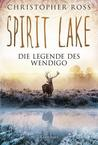

In [29]:
# Look at a random image
Image(books.loc['28575155', 'image_url'])

### Number of pages

In [30]:
books['num_pages'].head(5)

book_id
5333265    256.0
1333909      NaN
6066819    368.0
287140       NaN
287141     162.0
Name: num_pages, dtype: float32

In [31]:
books['num_pages'].describe()

count    1.279082e+06
mean     2.689515e+02
std      2.253817e+02
min      0.000000e+00
25%      1.600000e+02
50%      2.540000e+02
75%      3.520000e+02
max      8.200000e+04
Name: num_pages, dtype: float64

In [32]:
# We see that there are books with no pages, replace them with `None`
books.loc[books['num_pages'] == 0, 'num_pages'] = np.nan
print(f'Number of missing page number: {sum(books["num_pages"].isna())}')

Number of missing page number: 327293


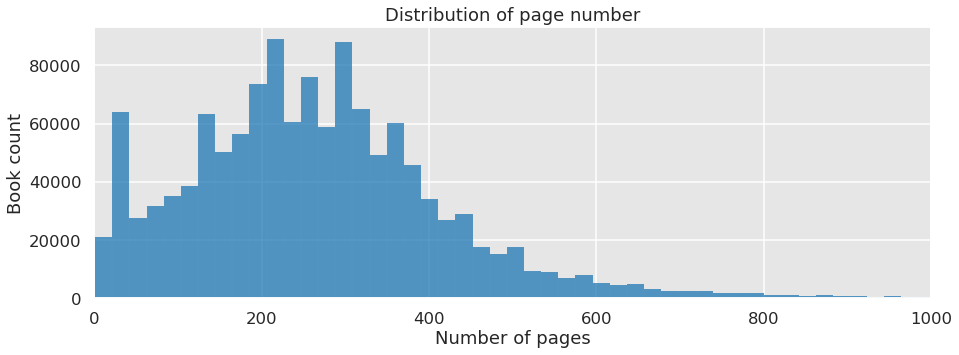

In [33]:
_, ax = plt.subplots(figsize=(15, 5))
sns.histplot(books['num_pages'], ax=ax, bins=4000)
ax.set_xlabel('Number of pages')
ax.set_ylabel('Book count')
ax.set_title('Distribution of page number')
ax.set_xlim(0, 1000)
plt.show()

### Year of publication

In [34]:
books['publication_year'].describe()

count    1.399962e+06
mean     2.007723e+03
std      2.083094e+02
min      1.000000e+00
25%      2.004000e+03
50%      2.010000e+03
75%      2.014000e+03
max      6.553500e+04
Name: publication_year, dtype: float64

We see that the values are widely scattered and there are obvious errors.

In [35]:
# Convert zeros to None
books.loc[books['publication_year'] == 0, 'publication_year'] = np.nan

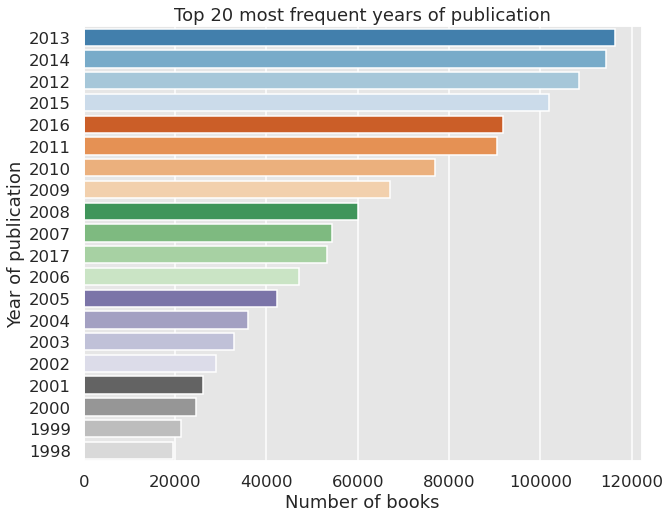

In [36]:
# Show most frequent years of publication
top_book_years = books['publication_year']\
    .value_counts().head(20).reset_index()
top_book_years.columns = ['year', 'count']
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=top_book_years['count'],
            y=top_book_years['year'].astype(int).astype(str),
            palette=sns_palette, ax=ax)
ax.set_ylabel('Year of publication')
ax.set_xlabel('Number of books')
ax.set_title('Top 20 most frequent years of publication')
plt.show()

### Description

In [37]:
# Remove extra spaces
books['description'] = books['description'].str.strip()\
    .replace(r'^\s*$', np.nan, regex=True)

# If there are empty descriptions
book_description_nans = books['description'].isna()
print(f'Number of books without a description: {sum(book_description_nans)}')

Number of books without a description: 210425


In [38]:
books.loc[book_description_nans].head(5)

,series,language_code,is_ebook,description,format,authors,publisher,num_pages,isbn13,edition_information,publication_year,image_url,ratings_count,work_id,title
book_id,,,,,,,,,,,,,,,
5333265,[],NaN,false,NaN,Paperback,"[{'author_id': '604031', 'role': ''}]",St. Martin's Press,256.0,9780312853129,NaN,1984.0,https://images.gr-assets.com/books/1310220028m...,3.0,5400751,W.C. Fields: A Life on Film
287140,[],NaN,false,NaN,NaN,"[{'author_id': '149918', 'role': ''}]",NaN,NaN,9780850308716,NaN,NaN,https://images.gr-assets.com/books/1413219371m...,15.0,278577,Runic Astrology: Starcraft and Timekeeping in ...
378460,[],NaN,false,NaN,Paperback,"[{'author_id': '215594', 'role': ''}]",Berkley Publishing Group,NaN,9780425040881,NaN,1979.0,NaN,12.0,368291,The Wanting of Levine
89373,[],eng,false,NaN,NaN,"[{'author_id': '3083854', 'role': ''}]",NaN,NaN,9785551180005,NaN,NaN,NaN,77.0,1080201,The Bonfire of the Vanities
21401188,[],eng,false,NaN,Paperback,"[{'author_id': '4092328', 'role': ''}]",Covenant Communications,160.0,9781621086949,NaN,2014.0,https://images.gr-assets.com/books/1395067717m...,72.0,40699074,Glimmering Light


In [39]:
# Show example of description
books.loc['28575155', 'description']

'Spirit Lake ist der Name des Indianerortes, in dem Allie McCormick nach einem Flugzeugabsturz strandet. Schnell merkt sie, dass es dort nicht mit rechten Dingen zugeht: Leute verschwinden, die Bewohner benehmen sich seltsam und im Internet existiert der Ort nicht. Als Allie durch den Indianerjungen Chris von der Legende des Wendigo erfahrt, wird klar, dass sie es mit einem ubermachtigen Gegner zu tun haben. Denn dieses Wesen hat ein Herz aus Eis, das nichts als Feuer furchtet ...'

### Language

In [40]:
# Unique values
books['language_code'].value_counts(dropna=False).head(10)

NaN      789340
eng      408069
en-US     58475
spa       41636
ita       37306
fre       26859
ger       24655
en-GB     23631
ind       22620
por       18629
Name: language_code, dtype: int64

The values are noisy. Let's try to fix this.

In [41]:
# The converted values are cached,
# so we can iterate over the dataframe fast enough
books['language'] = books['language_code'].apply(normalize_language_code)

In [42]:
books['language'].value_counts(dropna=False).head(10)

NaN           789385
English       491278
Spanish        41670
Italian        37306
French         26859
German         24655
Indonesian     22620
Portuguese     18667
Dutch          16137
Arabic         12378
Name: language, dtype: int64

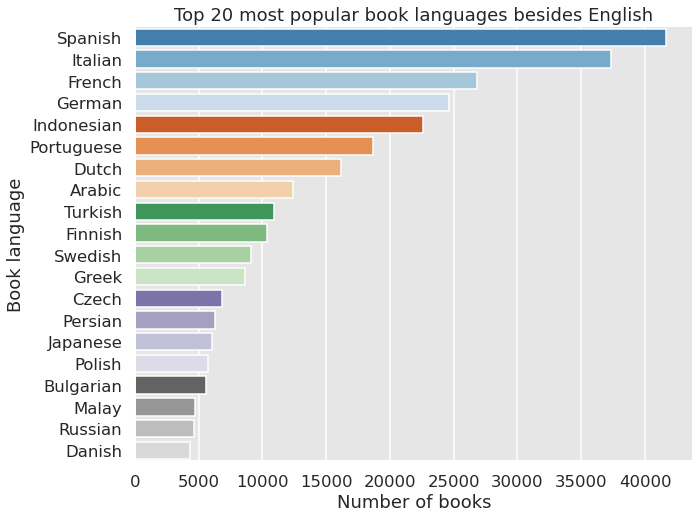

In [43]:
# Show most popular book languages besides English
top_book_langs = books['language'].value_counts()\
    .drop('English').head(20).reset_index()
top_book_langs.columns = ['language', 'count']
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=top_book_langs['count'],
            y=top_book_langs['language'],
            palette=sns_palette, ax=ax)
ax.set_ylabel('Book language')
ax.set_xlabel('Number of books')
ax.set_title('Top 20 most popular book languages besides English')
plt.show()

In [44]:
# Drop unused column
books.drop(columns=['language_code'], inplace=True)

### Format

Let's look at the values in the `is_ebook` and `format` columns.

In [45]:
books['is_ebook'].value_counts(dropna=False)

false    1454586
true      144544
Name: is_ebook, dtype: int64

In [46]:
# Remove extra spaces
books['format'] = books['format'].str.strip()\
    .replace(r'^\s*$', np.nan, regex=True)
books['format'].value_counts(dropna=False).head(20)

Paperback                808029
Hardcover                327162
NaN                      218014
ebook                    131534
Mass Market Paperback     35383
Audio CD                  29986
Audiobook                  9136
Audio                      8317
Unknown Binding            7412
Kindle Edition             4672
Board Book                 4197
Library Binding            1381
Board book                 1203
Audio Cassette             1064
Spiral-bound                937
MP3 CD                      909
paperback                   780
Leather Bound               666
Trade Paperback             604
Broche                      518
Name: format, dtype: int64

There are many book types, and most of them are written in different forms. It is possible to fix different names for the same things manually, but there are so many formats here that it's hard to do.

### Publisher

In [47]:
books['publisher'] = books['publisher'].str.strip()\
    .replace(r'^\s*$', np.nan, regex=True)
books['publisher'].value_counts(dropna=False).head(20)

NaN                                            208461
Createspace Independent Publishing Platform     18551
Smashwords Edition                              11265
Harlequin                                        9843
Createspace                                      9232
HarperCollins                                    7309
Oxford University Press, USA                     6729
Penguin Books                                    6432
Vintage                                          5835
Brilliance Audio                                 5560
Berkley                                          4738
Ballantine Books                                 4669
HarperCollins Publishers                         4622
Blackstone Audiobooks                            4420
Harlequin Books                                  4285
Bantam                                           4272
CreateSpace                                      4233
St. Martin's Press                               4088
Pocket Books                

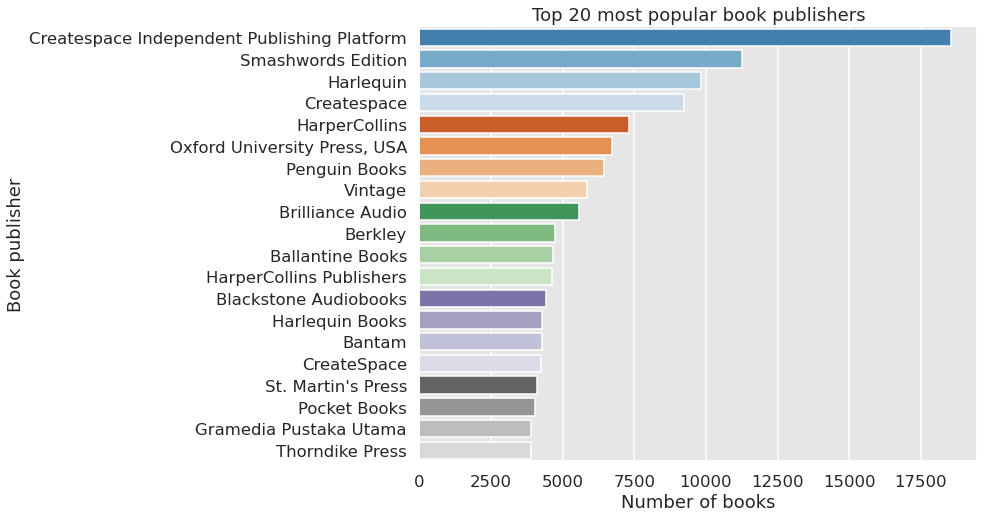

In [48]:
# Show most popular publishers
top_book_publishers = books['publisher'].value_counts()\
    .head(20).reset_index()
top_book_publishers.columns = ['publisher', 'count']
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=top_book_publishers['count'],
            y=top_book_publishers['publisher'],
            palette=sns_palette, ax=ax)
ax.set_ylabel('Book publisher')
ax.set_xlabel('Number of books')
ax.set_title('Top 20 most popular book publishers')
plt.show()

As in the previous case, there is a lot of missing and incorrect information. We see that "Harlequin" and "Harlequin Books" are different publishers here, but in reality they are the same. 

### Edition information

In [49]:
books['edition_information'] = books['edition_information']\
    .str.strip().replace(r'^\s*$', np.nan, regex=True)
books['edition_information'].value_counts(dropna=False).head(20)

NaN               1454697
Large Print          8924
1                    6546
First                5457
First Edition        5208
1st                  4250
Unabridged           4026
Abridged             3749
1st Edition          3048
1st edition          2602
Second Edition       2291
lTb`@ l'wl~          1658
2nd Edition          1177
first                1022
1a                    972
Third Edition         816
First edition         811
2nd                   738
2nd edition           699
Large print           696
Name: edition_information, dtype: int64

The situation with misprints is the same as in the previous cases.

### Authors

In [50]:
books[['authors', 'isbn13']].head(5)

,authors,isbn13
book_id,,
5333265,"[{'author_id': '604031', 'role': ''}]",9780312853129
1333909,"[{'author_id': '626222', 'role': ''}]",9780743509985
6066819,"[{'author_id': '9212', 'role': ''}]",9780743294294
287140,"[{'author_id': '149918', 'role': ''}]",9780850308716
287141,"[{'author_id': '3041852', 'role': ''}]",9781599150604


Each line contains the identifier of the author and his or her role in the creation of the book. Some books have several authors.

In [51]:
books_without_authors = ~books['authors'].astype(bool)
print(f'How many books do not have an author: {books_without_authors.sum()}')

How many books do not have an author: 28


In [52]:
# Normalize rows
book_authors = books[['authors']].explode('authors').dropna().reset_index()
book_authors = book_authors.drop('authors', axis=1)\
    .join(pd.DataFrame(book_authors['authors'].tolist()))
book_authors['role'] = book_authors['role']\
    .replace(r'^\s*$', np.nan, regex=True)
book_authors.head(10)

,book_id,author_id,role
0,5333265,604031,NaN
1,1333909,626222,NaN
2,6066819,9212,NaN
3,287140,149918,NaN
4,287141,3041852,NaN
5,378460,215594,NaN
6,6066812,19158,NaN
7,34883016,5807700,NaN
8,287149,2983296,NaN
9,287149,40075,Foreword by


In [53]:
book_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309552 entries, 0 to 2309551
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   book_id    object
 1   author_id  object
 2   role       object
dtypes: object(3)
memory usage: 52.9+ MB


In [54]:
book_authors.isna().any(axis=0)

book_id      False
author_id    False
role          True
dtype: bool

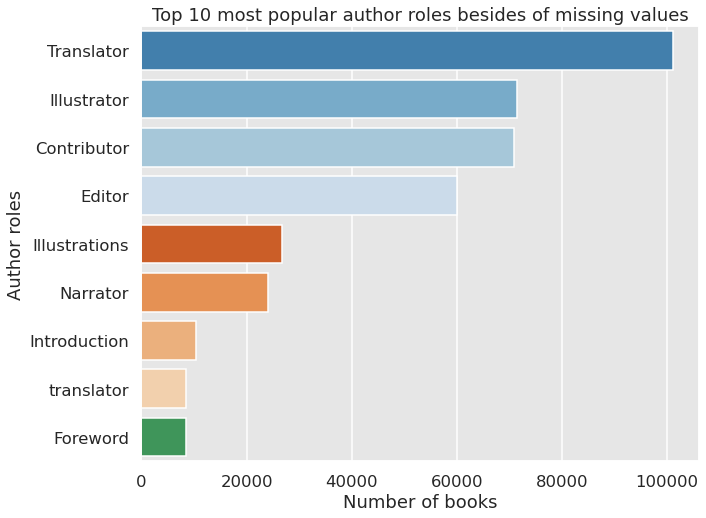

In [55]:
# Show most popular roles
top_book_roles = book_authors['role']\
    .value_counts(dropna=False).head(10).reset_index()
top_book_roles.columns = ['role', 'count']
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=top_book_roles['count'], y=top_book_roles['role'],
            palette=sns_palette, ax=ax)
ax.set_ylabel('Author roles')
ax.set_xlabel('Number of books')
ax.set_title('Top 10 most popular author roles besides of missing values')
plt.show()

We can suppose that missing values are the main author role.

In [56]:
# Drop author column, because we have a separate dataframe for authors
books.drop(columns=['authors'], inplace=True)

### Series

In [57]:
books[['series', 'isbn13']].head(10)

,series,isbn13
book_id,,
5333265,[],9780312853129
1333909,[],9780743509985
6066819,[],9780743294294
287140,[],9780850308716
287141,[],9781599150604
378460,[],9780425040881
6066812,[151854],9781934876565
34883016,[],9781370889471
287149,[],9780922915118


In [58]:
books_without_series = ~books['series'].astype(bool)
print(f'How many books are not in any series: {books_without_series.sum()}')

How many books are not in any series: 1133581


Thus, the majority of books is not in any series. However, some books are in several series.

In [59]:
# Normalize these rows
book_series = books[['series']].explode('series').dropna().reset_index()
book_series.head(10)

,book_id,series
0,6066812,151854
1,6066814,169353
2,89371,1070125
3,1902202,408775
4,4541271,250807
5,4541271,415703
6,4541271,181883
7,9671977,274410
8,13707894,414880
9,21401181,493993


In [60]:
# Drop series column, because we have a separate dataframe for series
books.drop(columns=['series'], inplace=True)

### Work id

Several ISBN's with the same title (but different year of publication, edition, etc.) are gathered in a book profile or in a work.

In [61]:
books[['work_id', 'isbn13']].head(10)

,work_id,isbn13
book_id,,
5333265,5400751,9780312853129
1333909,1323437,9780743509985
6066819,6243154,9780743294294
287140,278577,9780850308716
287141,278578,9781599150604
378460,368291,9780425040881
6066812,701117,9781934876565
34883016,56135087,9781370889471
287149,278586,9780922915118


In [62]:
# if there are missing values
books['work_id'].isna().sum()

22

It's strange enough.

---

## Authors

Detailed information about authors:
- `author_id`: unique author identifier
- `name`: first and last names
- `text_reviews_count`: number of text reviews to the author's books
- `ratings_count`: number of ratings to the author's books
- `average_rating`: average rating to the author's books

Here, we also will not analyze ratings, because there is more informative dataset of ratings.

In [63]:
author_cols = ['author_id', 'name']
author_dtypes = {'author_id': 'str', 'name': 'str'}
path_authors = os.path.join('data_original', 'goodreads_book_authors.json.csv')
authors = pd.read_csv(path_authors, usecols=author_cols, dtype=author_dtypes)
authors.head(10)

,author_id,name
0,604031,Ronald J. Fields
1,626222,Anita Diamant
2,10333,Barbara Hambly
3,9212,Jennifer Weiner
4,149918,Nigel Pennick
5,3041852,Alfred J. Church
6,215594,Michael Halberstam
7,19158,Rachel Roberts
8,5807700,V.L. Locey
9,2983296,Anton Szandor LaVey


In [64]:
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829529 entries, 0 to 829528
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   author_id  829529 non-null  object
 1   name       829524 non-null  object
dtypes: object(2)
memory usage: 12.7+ MB


In [65]:
authors.iloc[0]

author_id              604031
name         Ronald J. Fields
Name: 0, dtype: object

In [66]:
authors.isna().any(axis=0)

author_id    False
name          True
dtype: bool

In [67]:
# Check the integrity
authors['author_id'].is_unique

True

In [68]:
authors.set_index('author_id', drop=True, inplace=True)

In [69]:
# Strip and convert empty strings to NaN
authors['name'] = authors['name'].str.strip()\
    .replace(r'^\s*$', np.nan, regex=True)

# Show duplicated names
duplicates = authors['name'].duplicated(keep=False)
authors[duplicates].sort_values('name').head(10)

,name
author_id,
16624933,'Hmd Hsn
4407115,'Hmd Hsn
7210493,'Hmd SlH
5410175,'Hmd SlH
16021819,'Hmd Twswn
5297058,'Hmd Twswn
6432149,'Hmd `bd llTyf
6585874,'Hmd `bd llTyf
7553498,'Hmd `mr


It looks like misprints.

In [70]:
# Check if all authors from this dataset are in the book dataset
mask = authors.index.isin(book_authors['author_id'])
print(f'Number of redundant authors: {sum(~mask)}')

Number of redundant authors: 177545


In [71]:
# Redundant authors appeared because we removed books with incorrect ISBNs
# Drop redundant authors
authors = authors.loc[mask]

In [72]:
# Check if all authors from the book dataset are in the this dataset
book_authors['author_id'].isin(authors.index).all()

True

---

## Works

Here is information about book profiles — book description regardless of edition, ISBN: title, rating, year of publication, etc. Columns:

- `books_count`: number of books
- `reviews_count`: number of reviews
- `original_publication_month`: month of publication
- `default_description_language_code`: description language
- `text_reviews_count`: number of text reviews
- `best_book_id`: id of the best book
- `original_publication_year`: publication year
- `original_title`: original title
- `rating_dist`: rating distribution
- `default_chaptering_book_id`: meaning of this property is unknown
- `original_publication_day`: day of publication
- `original_language_id`: original language
- `ratings_count`: number of ratings
- `media_type`: book type (ebook, audio, etc.)
- `ratings_sum`: sum of work ratings
- `work_id`: id of the work

The work information is gathered from its books. Thus, there is no much sense to analyze these parameters in details.

In [73]:
works_cols = ['work_id', 'books_count', 'original_title',
              'default_description_language_code',
              'best_book_id', 'original_publication_year',
              'original_language_id', 'media_type']
works_types = {'work_id': 'str', 'books_count': 'int', 'original_title': 'str',
               'default_description_language_code': 'category',
               'best_book_id': 'str', 'original_publication_year': 'float',
               'original_language_id': 'category', 'media_type': 'category'}
path_works = os.path.join('data_original', 'goodreads_book_works.json.csv')
works = pd.read_csv(path_works, usecols=works_cols, dtype=works_types)

In [74]:
works.head(5)

,books_count,default_description_language_code,best_book_id,original_publication_year,original_title,original_language_id,media_type,work_id
0,1,NaN,5333265,1984.0,W. C. Fields: A Life on Film,NaN,book,5400751
1,22,NaN,25717,2001.0,Good Harbor,NaN,book,1323437
2,2,NaN,7327624,1987.0,NaN,NaN,book,8948723
3,38,NaN,6066819,2009.0,Best Friends Forever,NaN,book,6243154
4,2,NaN,287140,1990.0,Runic Astrology: Starcraft and Timekeeping in ...,NaN,book,278577


In [75]:
works.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521962 entries, 0 to 1521961
Data columns (total 8 columns):
 #   Column                             Non-Null Count    Dtype   
---  ------                             --------------    -----   
 0   books_count                        1521962 non-null  int64   
 1   default_description_language_code  0 non-null        category
 2   best_book_id                       1521962 non-null  object  
 3   original_publication_year          1269387 non-null  float64 
 4   original_title                     646905 non-null   object  
 5   original_language_id               0 non-null        category
 6   media_type                         1107866 non-null  category
 7   work_id                            1521962 non-null  object  
dtypes: category(3), float64(1), int64(1), object(3)
memory usage: 62.4+ MB


In [76]:
works['work_id'].is_unique

True

In [77]:
works.set_index('work_id', drop=True, inplace=True)

In [78]:
# Check if all works from this dataset are in the book dataset
mask = works.index.isin(books['work_id'])
print(f'Number of redundant works: {sum(~mask)}')

Number of redundant works: 440035


In [79]:
# Redundant works appeared because we removed books with incorrect ISBNs
# Drop redundant works
works = works.loc[mask]

In [80]:
# Check if all works from the book dataset are in the this dataset
books['work_id'].dropna().isin(works.index).all()

True

In [81]:
# Drop columns with NaNs
works.drop(columns=['default_description_language_code',
                    'original_language_id'],
           inplace=True)

### Media type

In [82]:
# Look at media_type column
works['media_type'].value_counts(dropna=False)

book          780227
NaN           300209
periodical       736
not a book       666
article           89
Name: media_type, dtype: int64

There are only four non-empty media types. However, in the book dataset there are much more types, but they are very noisy.

In [83]:
# Drop this column
works.drop(columns=['media_type'], inplace=True)

### Best book id

In [84]:
mask = ~works['best_book_id'].isin(books.index)
print(f'Number of missing book ids: {sum(mask)}')
works[mask].head(10)

Number of missing book ids: 89890


,books_count,best_book_id,original_publication_year,original_title
work_id,,,,
701117,11,18948499,2003.0,All's Fairy in Love and War (Avalon: Quest for...
54143148,5,33394837,NaN,NaN
1040345,20,7216124,1975.0,Des yeux de soie
150226,111,17660,1987.0,The Tommyknockers
363576,7,175557,1931.0,syr Hkhmt dr rwp
1409928,3,1419534,1981.0,Eighteenth Century Europe: Tradition and Progr...
1801666,2,1802481,2006.0,Cahier de gribouillages pour adultes qui s'enn...
1891601,3,1890255,1990.0,An Historical Introduction to American Education
18687450,7,13412895,1888.0,Ogni


There are a lot of missing book indexes in `best_book_id` column. We do not know the algorithm of choosing the best book for the work. Thus, we can propose our own:
- first, we choose books with non-empty title and year of publication
- next, we consider the book with number of ratings is better

In [85]:
books_cols = ['publication_year', 'title', 'work_id', 'ratings_count']
books_subset = books.loc[books['work_id'].isin(works[mask].index), books_cols]
books_subset['seq'] = 0
books_subset.loc[~books_subset['publication_year'].isna(), 'seq'] += 1
books_subset.loc[~books_subset['title'].isna(), 'seq'] += 1
books_subset.sort_values(by=['work_id', 'seq', 'ratings_count'],
                         inplace=True, ascending=False)
books_subset.drop_duplicates('work_id', keep='first', inplace=True)
books_subset['book_id'] = books_subset.index
books_subset.set_index('work_id', inplace=True, drop=True)
works.loc[books_subset.index,
          ['best_book_id', 'original_publication_year', 'original_title']] =\
    books_subset.loc[books_subset.index,
                     ['book_id', 'publication_year', 'title']].values

In [86]:
mask = ~works['best_book_id'].isin(books.index)
print(f'Number of missing book ids: {sum(mask)}')

Number of missing book ids: 0


### Books count

Next, we should refresh `books_count` value, because some books were removed.

In [87]:
works.head(5)

,books_count,best_book_id,original_publication_year,original_title
work_id,,,,
5400751,1,5333265,1984.0,W. C. Fields: A Life on Film
1323437,22,25717,2001.0,Good Harbor
6243154,38,6066819,2009.0,Best Friends Forever
278577,2,287140,1990.0,Runic Astrology: Starcraft and Timekeeping in ...
278578,21,287141,1908.0,The Aeneid for Boys and Girls


In [88]:
books_count = books[['work_id', 'isbn13']].groupby('work_id').count()
works['books_count'] = books_count['isbn13']

In [89]:
# Distribution of books number in works
works['books_count'].describe()

count    1.081927e+06
mean     1.478018e+00
std      2.544925e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.730000e+02
Name: books_count, dtype: float64

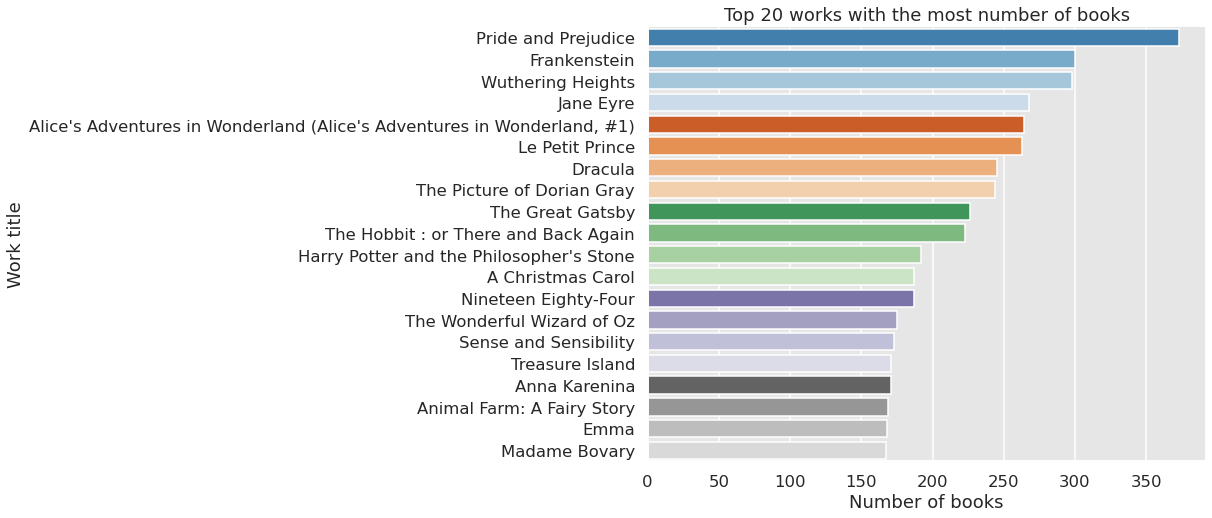

In [90]:
works_books_count_top = works.sort_values(by='books_count',
                                          ascending=False).head(20)

# Show
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=works_books_count_top['books_count'],
            y=works_books_count_top['original_title'],
            palette=sns_palette, ax=ax, ci=None)
ax.set_ylabel('Work title')
ax.set_xlabel('Number of books')
ax.set_title('Top 20 works with the most number of books')
plt.show()

---

## Series

Detailed information about book series:
- `series_id`: series identifier
- `numbered`: if the series is numbered
- `note`: comment
- `description`: series description
- `title`: name of series
- `series_works_count`: number of book profiles or works in series
- `primary_work_count`: meaning of this property is unknown

In [91]:
series_cols = ['series_id', 'numbered', 'note', 'description', 'title',
               'series_works_count']
series_dtypes = {'series_id': 'str', 'numbered': 'bool',
                 'series_works_count': 'int', 'note': 'str',
                 'description': 'str', 'title': 'str'}
path_series = os.path.join('data_original', 'goodreads_book_series.json.csv')
series = pd.read_csv(path_series, usecols=series_cols, dtype=series_dtypes)
series.head(10)

,numbered,note,description,title,series_works_count,series_id
0,True,NaN,NaN,Sun Wolf and Starhawk,9,189911
1,True,NaN,This series is also known as * Avalon : Jalina...,Avalon: Web of Magic,14,151854
2,True,NaN,"Plot-wise, ""Crowner's Crusade"" is a prequel to...",Crowner John Mystery,15,169353
3,True,NaN,NaN,Pluto's Snitch,3,1052227
4,False,NaN,NaN,"The Way, With The Enchanted Neighborhood",3,1070125
5,True,NaN,NaN,Dark Visions,4,147734
6,True,NaN,NaN,Inspector Capstan,4,953679
7,True,NaN,"When seven women get struck by lightning, they...","Dante's Circle,",13,811663
8,True,NaN,"Patrick Grant, a professor and amateur sleuth,...",Patrick Grant,5,408775
9,True,NaN,Part of the . The Foundation series is a scie...,Foundation (Publication Order),4,250807


In [92]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400390 entries, 0 to 400389
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   numbered            400390 non-null  bool  
 1   note                25279 non-null   object
 2   description         151019 non-null  object
 3   title               400384 non-null  object
 4   series_works_count  400390 non-null  int64 
 5   series_id           400390 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 15.7+ MB


In [93]:
series.isna().any(axis=0)

numbered              False
note                   True
description            True
title                  True
series_works_count    False
series_id             False
dtype: bool

### Id

In [94]:
series['series_id'].is_unique

True

In [95]:
series.set_index('series_id', drop=True, inplace=True)

In [96]:
# Check if all series from this dataset are in the book dataset
mask = series.index.isin(book_series['series'])
print(f'Number of redundant series: {sum(~mask)}')

Number of redundant series: 124047


In [97]:
# Redundant series appeared because we removed books with incorrect ISBNs
# Drop redundant series
series = series.loc[mask]

In [98]:
# Check if all series  from the book dataset are in the this dataset
book_series['series'].isin(series.index).all()

True

### Description, note, title

In [99]:
cols = ['description', 'note', 'title']
for col in cols:
    series[col] = series[col].str.strip().replace(r'^\s*$', np.nan, regex=True)
series[cols].isna().sum()

description    158784
note           256968
title               4
dtype: int64

More than a half of series do not have a description.

In [100]:
# Check for duplicates in the title column
series['title'].is_unique

False

In [101]:
# Show duplicates
mask = series['title'].duplicated(keep=False)
series[mask].sort_values('title').head(10)

,numbered,note,description,title,series_works_count
series_id,,,,,
1139967,False,NaN,NaN,!Mira que artista!,5
1139969,False,NaN,NaN,!Mira que artista!,5
1139970,False,NaN,NaN,!Mira que artista!,5
1139968,False,NaN,NaN,!Mira que artista!,5
530565,True,NaN,(this is also known as the Jeff Barkil adventu...,"""Halo""",4
530561,True,NaN,(this is also known as the Jeff Barkil adventu...,"""Halo""",4
530562,True,NaN,(this is also known as the Jeff Barkil adventu...,"""Halo""",4
530566,True,NaN,(this is also known as the Jeff Barkil adventu...,"""Halo""",4
802769,True,NaN,"2011. gada, rakstnieces Gundegas Repses iedves...","""Mes. Latvija, XX gadsimts""",12


There are a lot of duplicates. Look at the famous series:

In [102]:
series[series['title'] == 'Harry Potter']

,numbered,note,description,title,series_works_count
series_id,,,,,
167817,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
624922,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
615726,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
169291,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
162083,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
164829,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
163765,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
1055430,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13
1040116,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13


It is possible to gather duplicates in one series, and fix the corresponding `series_id` in the book dataset:

In [103]:
# Find all duplicated rows
series_duplicates = series[series.duplicated(keep=False)]

# Group them and get indexes
series_duplicates_idx = series_duplicates\
    .groupby(series_duplicates.columns.tolist())\
    .apply(lambda x: list(x.index)).tolist()

# Iterate over each group and keep only one series id
to_replace = {}
for series_group in series_duplicates_idx:
    to_leave = series_group.pop()
    for index in series_group:
        to_replace[index] = to_leave

# Drop duplicates from the series
series.drop(index=to_replace.keys(), inplace=True)

# Replace in the book series
book_series['series'].replace(to_replace, inplace=True)

In [104]:
# Now we see only one row per series with the same properties
series[series['title'] == 'Harry Potter']

,numbered,note,description,title,series_works_count
series_id,,,,,
874655,True,Cursed Child is NOT a Primary Work. Boxsets AR...,Orphan Harry learns he is a wizard on his 11th...,Harry Potter,13


In [105]:
# After removing the duplicates, the number of series decreased greatly
series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261660 entries, 151854 to 618749
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   numbered            261660 non-null  bool  
 1   note                4692 non-null    object
 2   description         102876 non-null  object
 3   title               261656 non-null  object
 4   series_works_count  261660 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 10.2+ MB


### Numbered

In [106]:
# Look at the values distribution
series['numbered'].value_counts(dropna=False)

True     229003
False     32657
Name: numbered, dtype: int64

Most of the series are numbered.

### Works count

In [107]:
series[['series_works_count']].head(5)

,series_works_count
series_id,
151854,14
169353,15
1052227,3
1070125,3
147734,4


We need to update these values, because the works and books dataset were modified.

In [108]:
series_works = pd.merge(book_series, books[['work_id']],
                        left_on='book_id', right_index=True, how='left')
series_works.drop_duplicates(['work_id', 'series'], inplace=True)
series_works_count = series_works[['series', 'work_id']]\
    .groupby('series').count()
series['series_works_count'] = series_works_count['work_id']

In [109]:
series['series_works_count'].describe()

count    261660.000000
mean          1.056115
std           2.053358
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         502.000000
Name: series_works_count, dtype: float64

75% of series consists of 2 works or fewer.

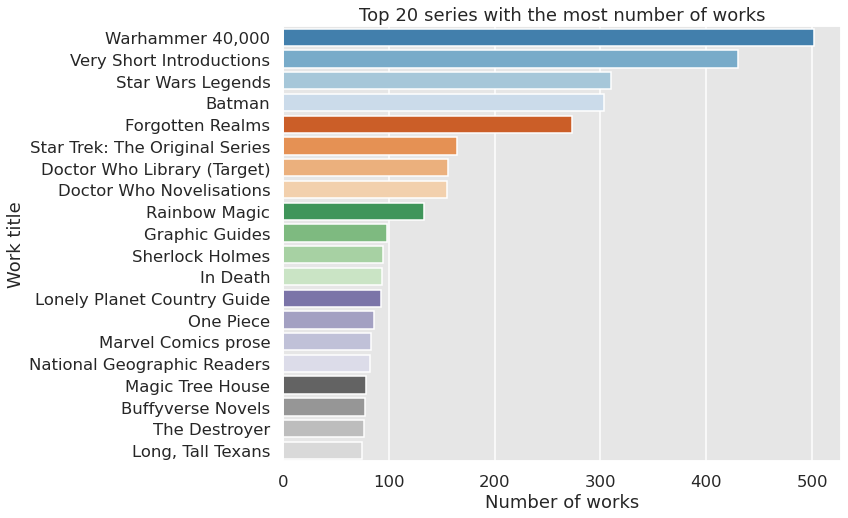

In [110]:
series_works_count_top = series.sort_values(by='series_works_count',
                                            ascending=False).head(20)

# Show
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=series_works_count_top['series_works_count'],
            y=series_works_count_top['title'],
            palette=sns_palette, ax=ax, ci=None)
ax.set_ylabel('Work title')
ax.set_xlabel('Number of works')
ax.set_title('Top 20 series with the most number of works')
plt.show()

---

## Ratings

Columns:
- `user_id`: id of users
- `book_id`: id of books
- `rating`: rating value
- `is_reviewed`: if the user left text review
- `is_read`: if the user has read the rated book

In [111]:
ratings_cols = ['user_id', 'book_id', 'rating', 'is_reviewed', 'is_read']

ratings_dtypes = {
    'user_id': 'category', 'book_id': 'category', 'rating': 'uint8',
    'is_reviewed': 'bool', 'is_read': 'bool',
}

ratings = pd.read_csv(
    os.path.join('data_original', 'goodreads_interactions.csv'),
    usecols=ratings_cols, dtype=ratings_dtypes)
user_id_map = pd.read_csv(os.path.join('data_original', 'user_id_map.csv'),
                          usecols=['user_id_csv', 'user_id'],
                          dtype={'user_id_csv': 'category', 'user_id': 'category'})
book_id_map = pd.read_csv(os.path.join('data_original', 'book_id_map.csv'),
                          usecols=['book_id_csv', 'book_id'],
                          dtype={'book_id_csv': 'category', 'book_id': 'category'})

In [112]:
ratings.head(5)

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,True,5,False
1,0,947,True,5,True
2,0,946,True,5,False
3,0,945,True,5,False
4,0,944,True,5,False


In [113]:
book_id_map.head(5)

,book_id_csv,book_id
0,0,34684622
1,1,34536488
2,2,34017076
3,3,71730
4,4,30422361


In [114]:
user_id_map.head(5)

,user_id_csv,user_id
0,0,8842281e1d1347389f2ab93d60773d4d
1,1,72fb0d0087d28c832f15776b0d936598
2,2,ab2923b738ea3082f5f3efcbbfacb218
3,3,d986f354a045ffb91234e4af4d1b12fd
4,4,7504b2aee1ecb5b2872d3da381c6c91e


In [115]:
# Concat 
ratings = pd.merge(ratings, book_id_map, left_on='book_id',
                   right_on='book_id_csv', how='left')
ratings = pd.merge(ratings, user_id_map, left_on='user_id',
                   right_on='user_id_csv', how='left')
ratings.drop(columns=['book_id_x', 'book_id_csv',
                      'user_id_csv', 'user_id_x'],
             inplace=True)
ratings.rename(columns={'book_id_y': 'book_id',
                        'user_id_y': 'user_id'},
               inplace=True)

In [116]:
ratings.head(5)

,is_read,rating,is_reviewed,book_id,user_id
0,True,5,False,12,8842281e1d1347389f2ab93d60773d4d
1,True,5,True,21,8842281e1d1347389f2ab93d60773d4d
2,True,5,False,30,8842281e1d1347389f2ab93d60773d4d
3,True,5,False,45,8842281e1d1347389f2ab93d60773d4d
4,True,5,False,1,8842281e1d1347389f2ab93d60773d4d


In [117]:
ratings.dtypes

is_read            bool
rating            uint8
is_reviewed        bool
book_id        category
user_id        category
dtype: object

In [118]:
# Check if all ratings from this dataset are in the book dataset
mask = ratings['book_id'].isin(books.index)
print(f'Number of redundant ratings: {sum(~mask)}')

Number of redundant ratings: 34974356


In [119]:
# Redundant ratings appeared because we removed books with incorrect ISBNs
# Drop redundant ratings
ratings = ratings.loc[mask]

In [120]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193673986 entries, 0 to 228648340
Data columns (total 5 columns):
 #   Column       Dtype   
---  ------       -----   
 0   is_read      bool    
 1   rating       uint8   
 2   is_reviewed  bool    
 3   book_id      category
 4   user_id      category
dtypes: bool(2), category(2), uint8(1)
memory usage: 3.5 GB


In [121]:
ratings.isna().any(axis=0)

is_read        False
rating         False
is_reviewed    False
book_id        False
user_id        False
dtype: bool

In [122]:
# The zero rating means "not provided", so change them to NaNs
ratings['rating'].replace(0, np.nan, inplace=True)

In [123]:
ratings.head(5)

,is_read,rating,is_reviewed,book_id,user_id
0,True,5.0,False,12,8842281e1d1347389f2ab93d60773d4d
1,True,5.0,True,21,8842281e1d1347389f2ab93d60773d4d
2,True,5.0,False,30,8842281e1d1347389f2ab93d60773d4d
3,True,5.0,False,45,8842281e1d1347389f2ab93d60773d4d
4,True,5.0,False,1,8842281e1d1347389f2ab93d60773d4d


In [124]:
explicit_ratings = ratings[~ratings['rating'].isna()]

### Book

In [125]:
explicit_ratings['is_read'].all()

True

Each explicit rating is from a user who read the book.

Text(0.5, 1.0, 'Books rating distribution')

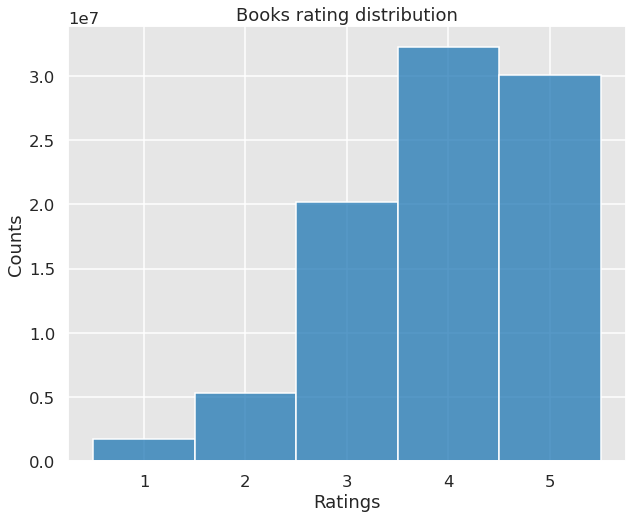

In [126]:
_, ax = plt.subplots(figsize=(10, 8))
sns.histplot(explicit_ratings['rating'], ax=ax, discrete=True)
ax.set_ylabel('Counts')
ax.set_xlabel('Ratings')
ax.set_title('Books rating distribution')

Thus, there are much more positive ratings than negative.

In [127]:
by_book = ratings[['book_id', 'rating', 'is_read', 'is_reviewed']]\
    .groupby('book_id', observed=True)
by_book_count = by_book[['rating']].count()
by_book_sum = by_book[['is_read', 'is_reviewed']].sum()

In [128]:
book_rated_count = len(by_book_count)
book_5times_rated_count = (by_book_count['rating'] >= 5).sum()

print(f'Number of books which have ratings: {book_rated_count} '
      f'that is {book_rated_count * 100 / len(books):.4f}%')
print(f'Number of books which have at least 5 ratings: '
      f'{book_5times_rated_count} that is '
      f'{book_5times_rated_count * 100 / len(books):.4f}%')

Number of books which have ratings: 1599129 that is 99.9999%
Number of books which have at least 5 ratings: 802537 that is 50.1859%


Let's calculate weighted ratings of books. To use usual rating is not the best idea, because a book with a rating of 9 from 10 voters will be considered 'better' than a book with a rating of 8.9 from 10,000 voters. Thus, it is better to use "weighted rating". See more details [in the Datacamp article](https://www.datacamp.com/community/tutorials/recommender-systems-python).

In [129]:
# Calculate weighted rating
min_book_rate_count = by_book_count['rating'].quantile(0.90)
mean_book_rate = ratings['rating'].mean(skipna=True)
books_ids = by_book_count[by_book_count['rating'] >= min_book_rate_count].index
by_book_weighted = ratings\
    .loc[ratings['book_id'].isin(books_ids), ['book_id', 'rating']]\
    .groupby('book_id', observed=True).apply(get_weighted_rating,
                                             min_rate_count=min_book_rate_count,
                                             mean_rate=mean_book_rate)\
    .to_frame(name='weighted_rating')

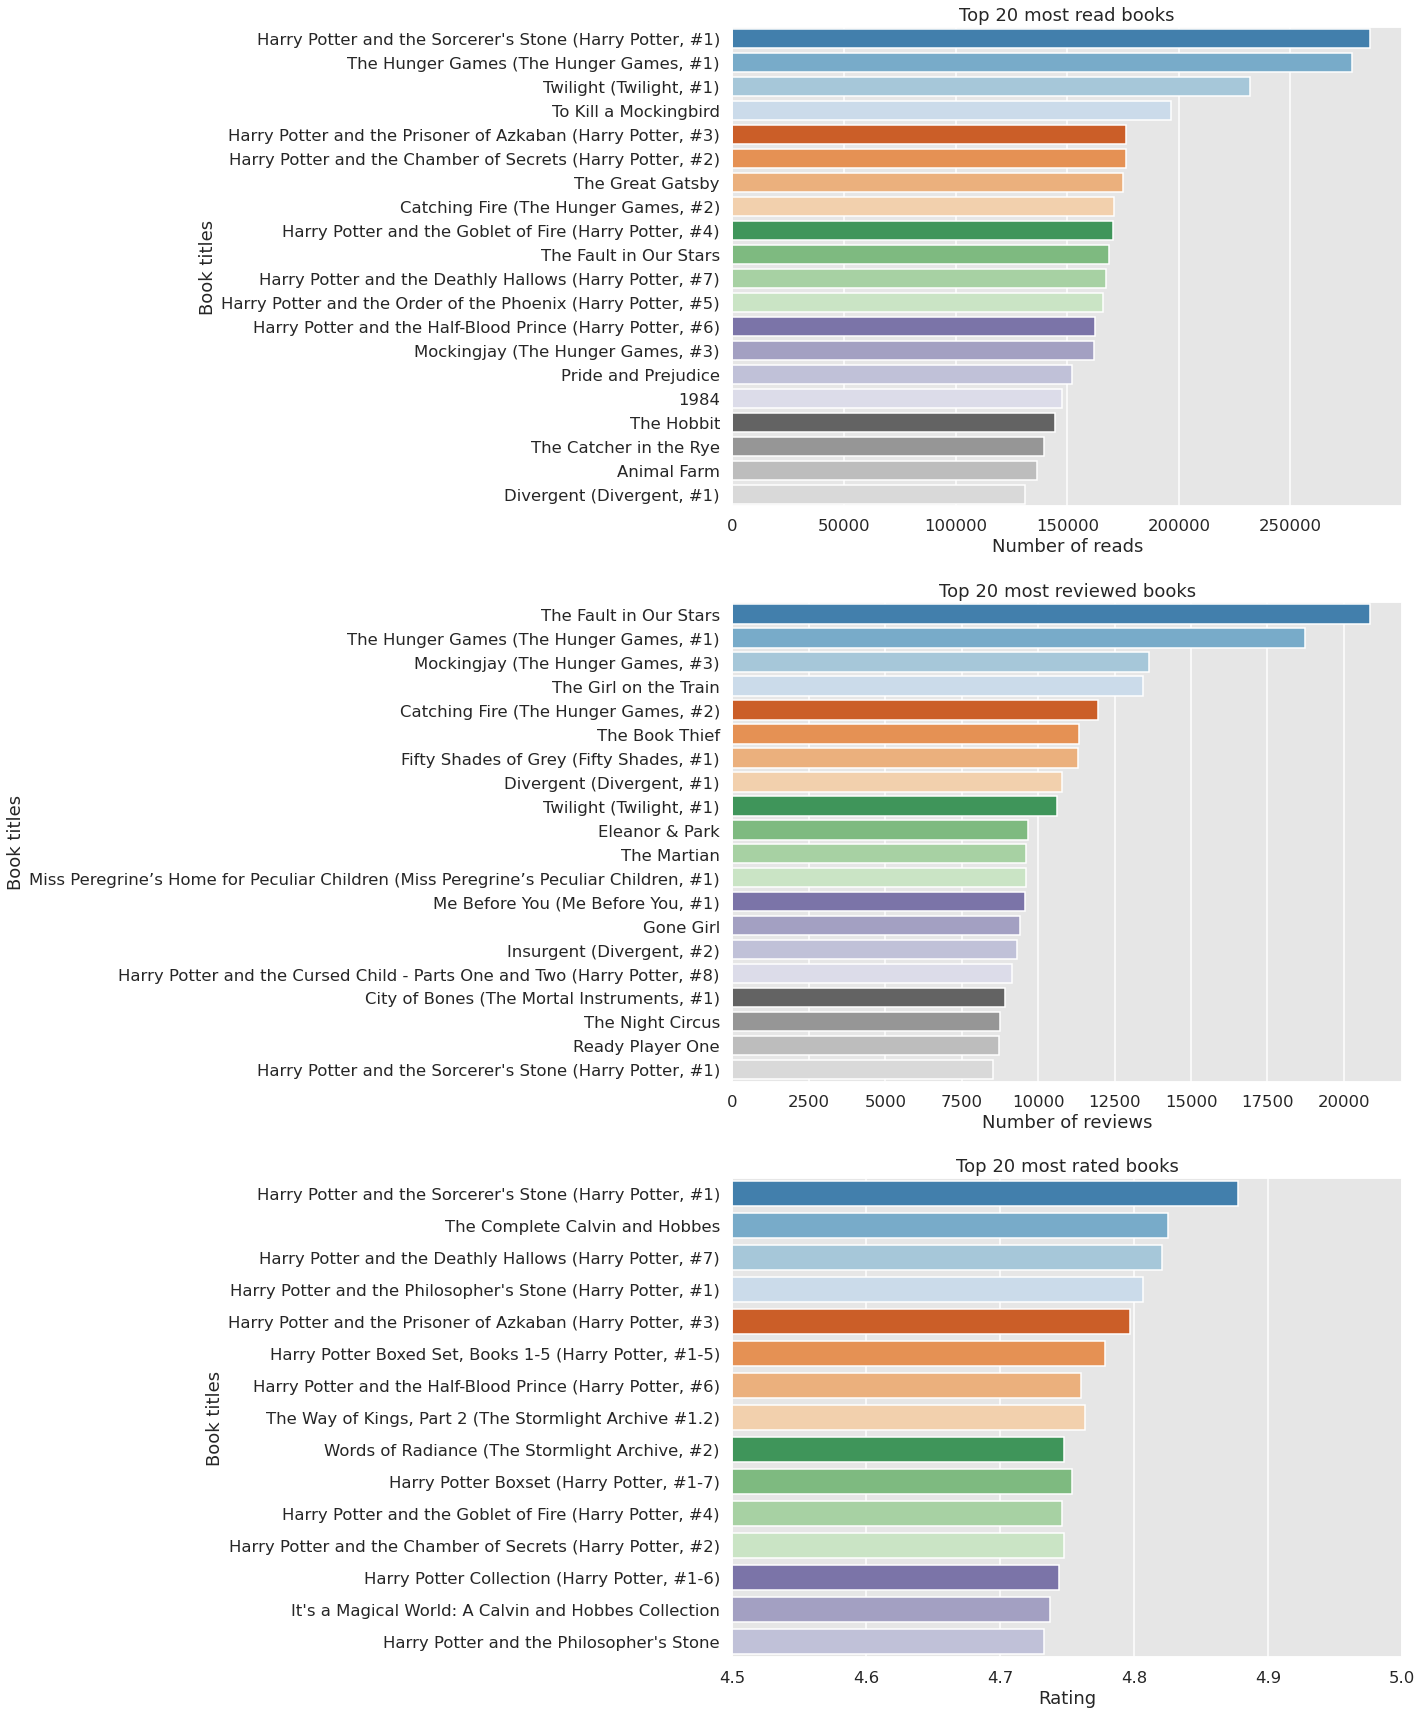

In [130]:
_, ax = plt.subplots(nrows=3, figsize=(12, 30))

# Most read books
books_most_read_top = by_book_sum\
    .sort_values(by='is_read', ascending=False).head(20)
books_most_read_top = pd.merge(books_most_read_top,
                               books[['title']], how='left',
                               right_index=True, left_index=True)
sns.barplot(x=books_most_read_top['is_read'],
            y=books_most_read_top['title'],
            palette=sns_palette, ax=ax[0], ci=None)
ax[0].set_ylabel('Book titles')
ax[0].set_xlabel('Number of reads')
ax[0].set_title('Top 20 most read books')

# Most reviewed books
books_most_reviewed_top = by_book_sum\
    .sort_values(by='is_reviewed', ascending=False).head(20)
books_most_reviewed_top = pd.merge(books_most_reviewed_top,
                                   books[['title']], how='left',
                                   right_index=True, left_index=True)
sns.barplot(x=books_most_reviewed_top['is_reviewed'],
            y=books_most_reviewed_top['title'],
            palette=sns_palette, ax=ax[1], ci=None)
ax[1].set_ylabel('Book titles')
ax[1].set_xlabel('Number of reviews')
ax[1].set_title('Top 20 most reviewed books')

# Most rated books
high_rated_books_top = by_book_weighted\
    .sort_values(by='weighted_rating', ascending=False).head(20)
high_rated_books_top = pd.merge(high_rated_books_top,
                                books[['title']], how='left',
                                right_index=True, left_index=True)
sns.barplot(x=high_rated_books_top['weighted_rating'],
            y=high_rated_books_top['title'],
            palette=sns_palette, ax=ax[2], ci=None)
ax[2].set_xlim(4.5, 5)
ax[2].set_ylabel('Book titles')
ax[2].set_xlabel('Rating')
ax[2].set_title('Top 20 most rated books')
plt.show()

In [131]:
by_user = ratings[['user_id', 'rating', 'is_read', 'is_reviewed']]\
    .groupby('user_id', observed=True)
by_user_count = by_user.count()
by_user_sum = by_user.sum()
print(f'Number of users who left ratings: {len(by_user_count)}')
print(f'Number of users who left at least 5 ratings: '
      f'{(by_user_count["rating"] >= 5).sum()}')

Number of users who left ratings: 869301
Number of users who left at least 5 ratings: 737464


We can also show users with the number of ratings, the most negative and positive rating. But we will not, because users are anonymized and there is nothing interesting here.

### Work

Earlier we saw several charts for particular ISBNs. Let's show the same for works.

In [132]:
works_ratings = pd.merge(
    ratings[['book_id', 'rating', 'is_read', 'is_reviewed']],
    books[['work_id']], how='left',
    right_index=True, left_on='book_id')

In [133]:
by_work = works_ratings[['rating', 'is_read', 'is_reviewed', 'work_id']]\
    .groupby('work_id', observed=True)
by_work_count = by_work[['rating']].count()
by_work_sum = by_work[['is_read', 'is_reviewed']].sum()

In [134]:
# Calculate weighted rating
min_work_rate_count = by_work_count['rating'].quantile(0.90)
mean_work_rate = works_ratings['rating'].mean(skipna=True)
works_ids = by_work_count[by_work_count['rating'] >= min_work_rate_count].index
by_work_weighted = works_ratings\
    .loc[works_ratings['work_id'].isin(works_ids), ['work_id', 'rating']]\
    .groupby('work_id', observed=True).apply(get_weighted_rating,
                                             min_rate_count=min_work_rate_count,
                                             mean_rate=mean_work_rate)\
    .to_frame(name='weighted_rating')

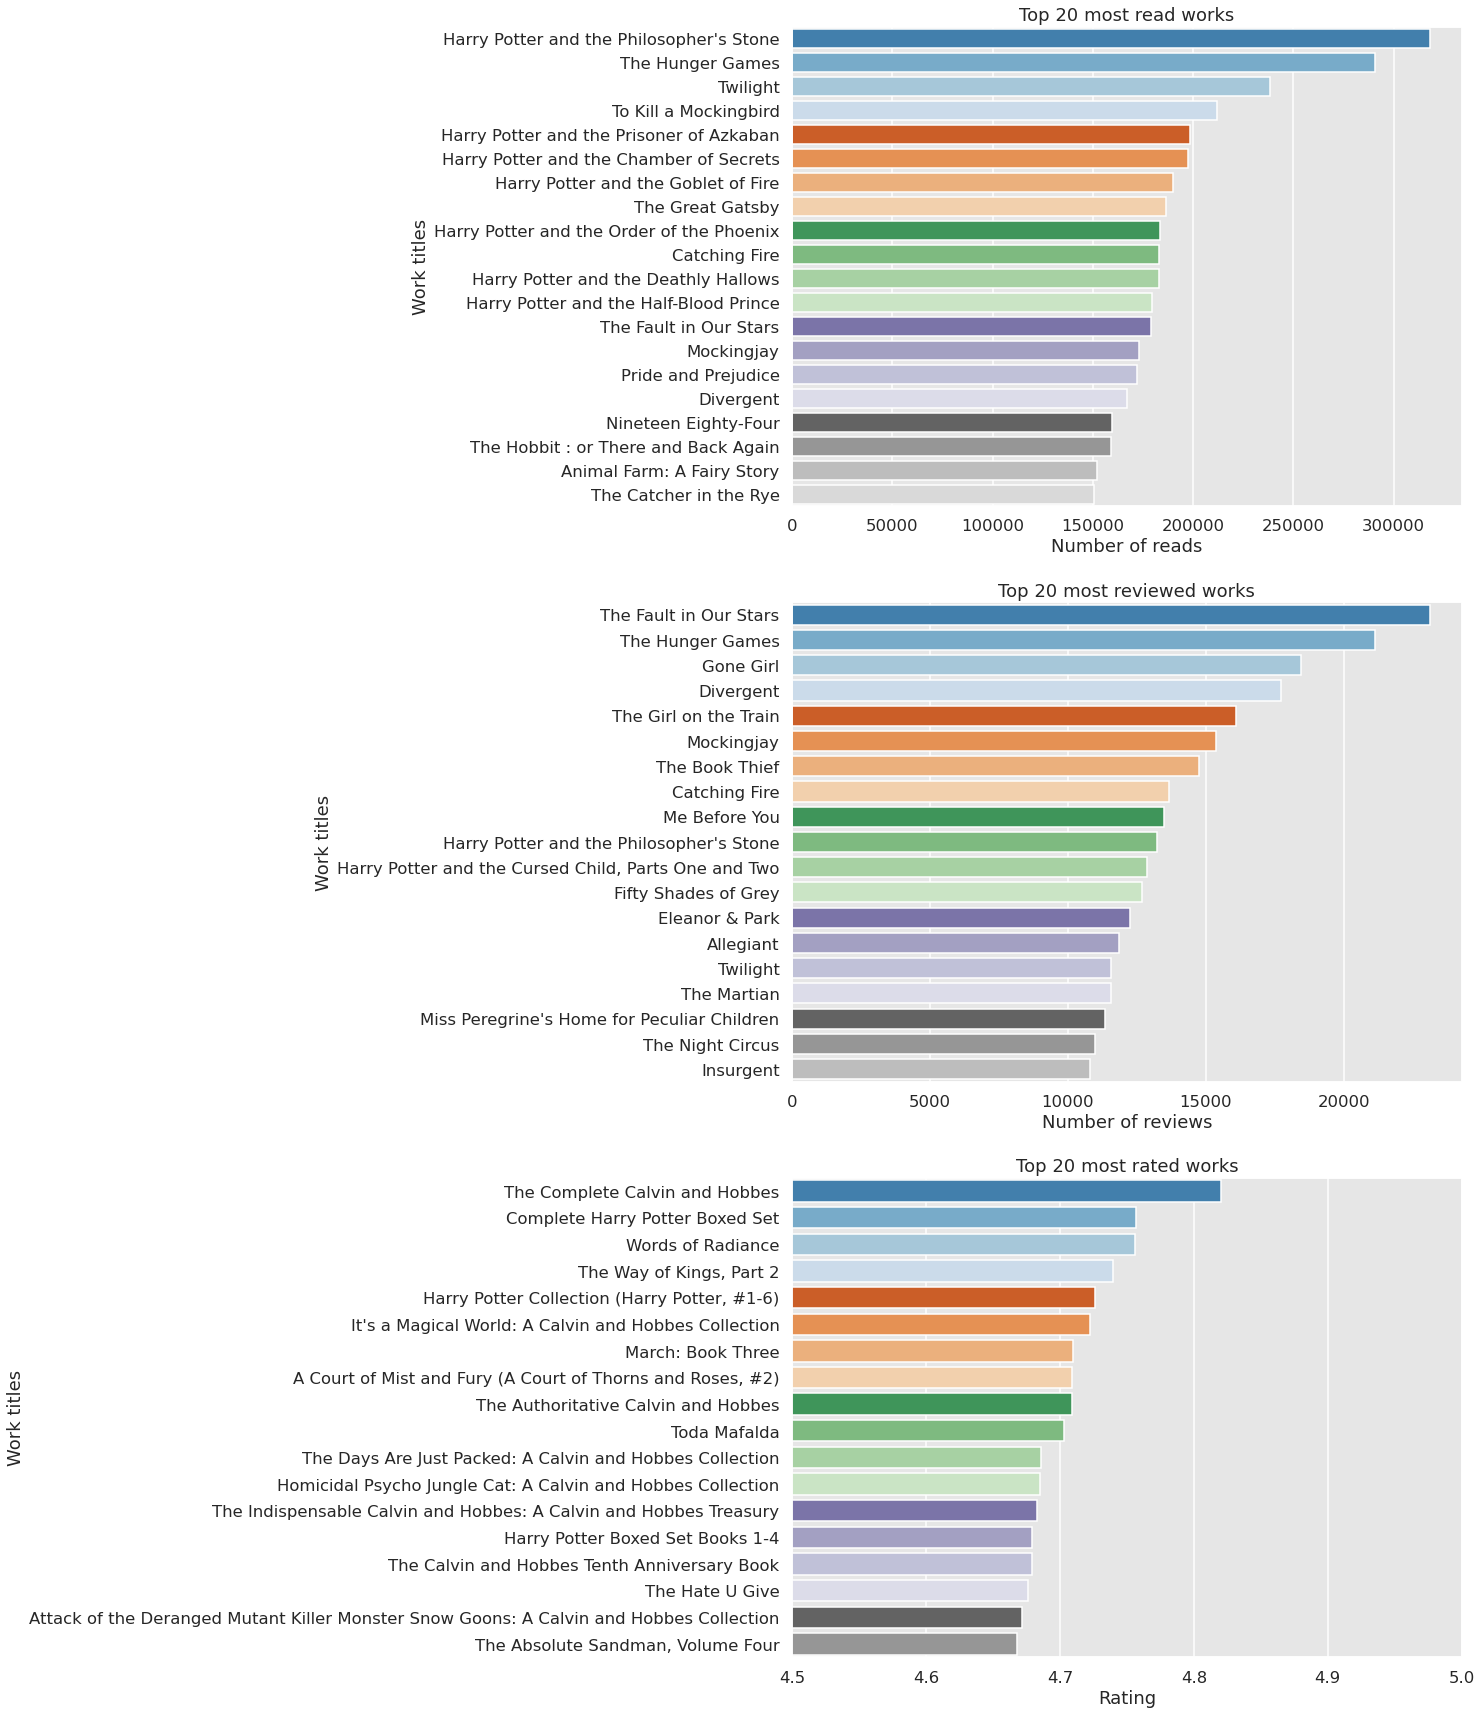

In [135]:
_, ax = plt.subplots(nrows=3, figsize=(12, 30))

# Most read works
works_most_read_top = by_work_sum\
    .sort_values(by='is_read', ascending=False).head(20)
works_most_read_top = pd.merge(works_most_read_top,
                               works[['original_title']], how='left',
                               right_index=True, left_index=True)
sns.barplot(x=works_most_read_top['is_read'],
            y=works_most_read_top['original_title'],
            palette=sns_palette, ax=ax[0], ci=None)
ax[0].set_ylabel('Work titles')
ax[0].set_xlabel('Number of reads')
ax[0].set_title('Top 20 most read works')

# Most reviewed works
works_most_reviewed_top = by_work_sum\
    .sort_values(by='is_reviewed', ascending=False).head(20)
works_most_reviewed_top = pd.merge(works_most_reviewed_top,
                                   works[['original_title']], how='left',
                                   right_index=True, left_index=True)
sns.barplot(x=works_most_reviewed_top['is_reviewed'],
            y=works_most_reviewed_top['original_title'],
            palette=sns_palette, ax=ax[1], ci=None)
ax[1].set_ylabel('Work titles')
ax[1].set_xlabel('Number of reviews')
ax[1].set_title('Top 20 most reviewed works')

# Most rated works
high_rated_works_top = by_work_weighted\
    .sort_values(by='weighted_rating', ascending=False).head(20)
high_rated_works_top = pd.merge(high_rated_works_top,
                                works[['original_title']], how='left',
                                right_index=True, left_index=True)
sns.barplot(x=high_rated_works_top['weighted_rating'],
            y=high_rated_works_top['original_title'],
            palette=sns_palette, ax=ax[2], ci=None)
ax[2].set_xlim(4.5, 5)
ax[2].set_ylabel('Work titles')
ax[2].set_xlabel('Rating')
ax[2].set_title('Top 20 most rated works')
plt.show()

### Author

Let's assume that each rating is not for a book but for an author.

In [136]:
author_ratings = pd.merge(
    ratings[['book_id', 'rating', 'is_read', 'is_reviewed']],
    book_authors[['book_id', 'author_id']],
    how='left', on='book_id')

In [137]:
by_author = author_ratings[['rating', 'is_read', 'is_reviewed', 'author_id']]\
    .groupby('author_id', observed=True)
by_author_count = by_author[['rating']].count()
by_author_sum = by_author[['is_read', 'is_reviewed']].sum()

In [138]:
# Calculate weighted ratings
min_author_rate_count = by_author_count['rating'].quantile(0.95)
mean_author_rate = author_ratings['rating'].mean(skipna=True)
author_ids =\
    by_author_count[by_author_count['rating'] >= min_author_rate_count].index
by_author_weighted = author_ratings\
    .loc[author_ratings['author_id'].isin(author_ids),
         ['author_id', 'rating']]\
    .groupby('author_id', observed=True).apply(get_weighted_rating,
                                               min_rate_count=min_author_rate_count,
                                               mean_rate=mean_author_rate)\
    .to_frame(name='weighted_rating')

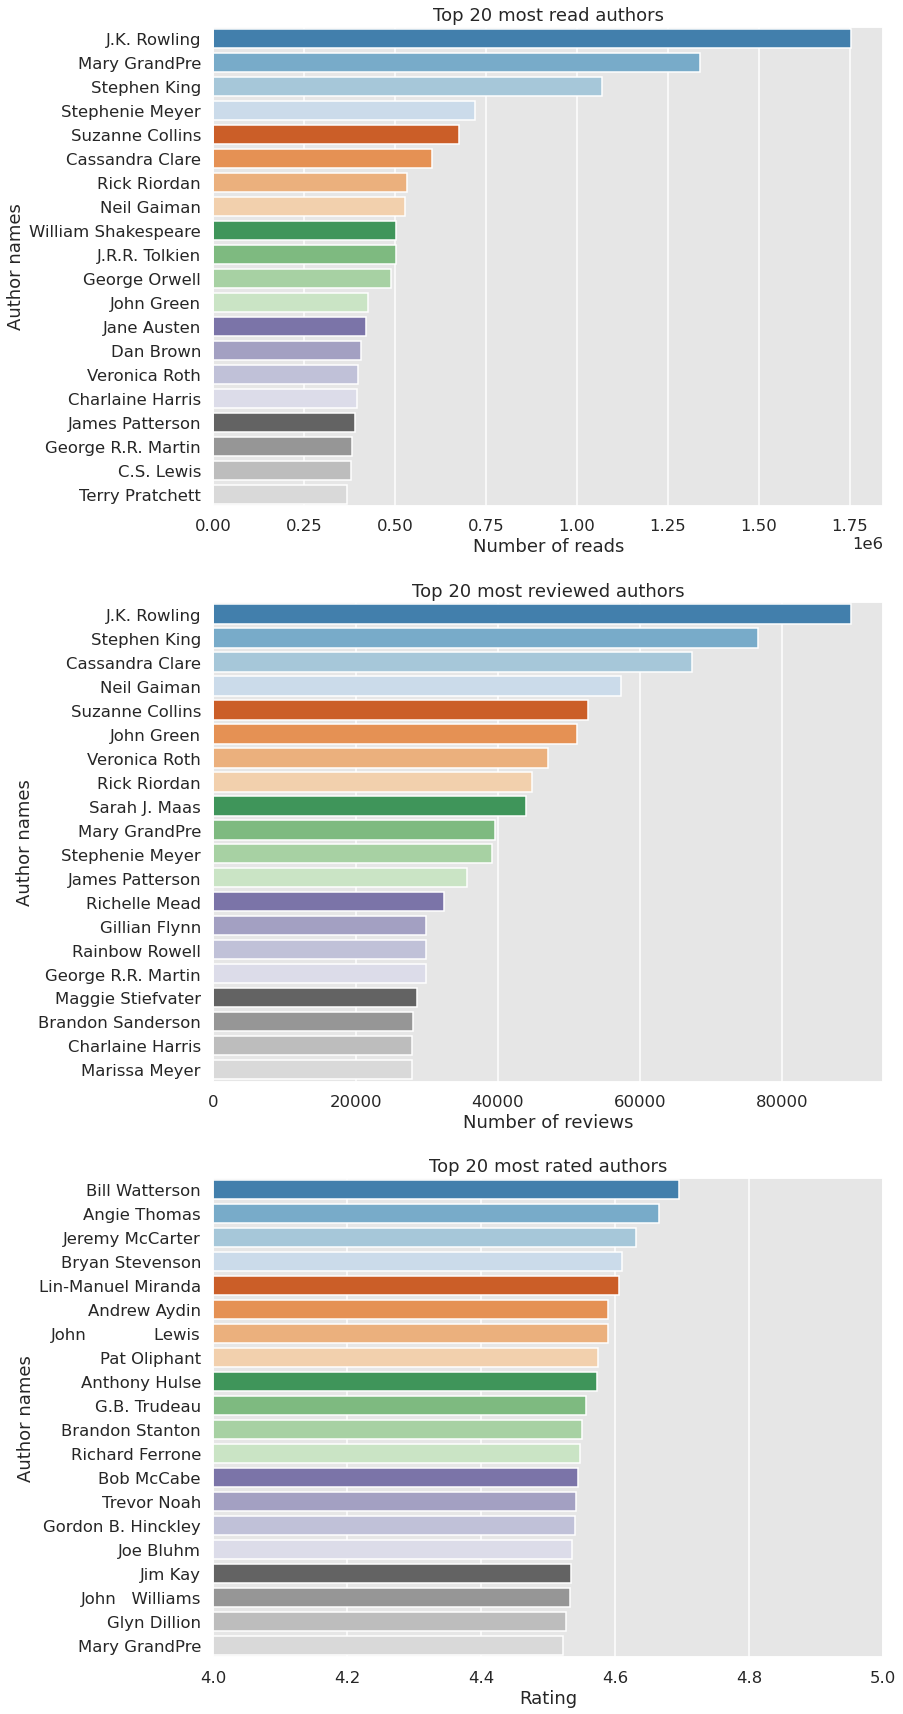

In [139]:
_, ax = plt.subplots(nrows=3, figsize=(12, 30))

# Most read authors
authors_most_read_top = by_author_sum\
    .sort_values(by='is_read', ascending=False).head(20)
authors_most_read_top = pd.merge(authors_most_read_top,
                                 authors[['name']], how='left',
                                 right_index=True, left_index=True)
sns.barplot(x=authors_most_read_top['is_read'],
            y=authors_most_read_top['name'],
            palette=sns_palette, ax=ax[0], ci=None)
ax[0].set_ylabel('Author names')
ax[0].set_xlabel('Number of reads')
ax[0].set_title('Top 20 most read authors')

# Most reviewed authors
authors_most_reviewed_top = by_author_sum\
    .sort_values(by='is_reviewed', ascending=False).head(20)
authors_most_reviewed_top = pd.merge(authors_most_reviewed_top,
                                     authors[['name']], how='left',
                                     right_index=True, left_index=True)
sns.barplot(x=authors_most_reviewed_top['is_reviewed'],
            y=authors_most_reviewed_top['name'],
            palette=sns_palette, ax=ax[1], ci=None)
ax[1].set_ylabel('Author names')
ax[1].set_xlabel('Number of reviews')
ax[1].set_title('Top 20 most reviewed authors')

# Most rated authors
high_rated_authors_top = by_author_weighted\
    .sort_values(by='weighted_rating', ascending=False).head(20)
high_rated_authors_top = pd.merge(high_rated_authors_top,
                                  authors[['name']], how='left',
                                  right_index=True, left_index=True)
sns.barplot(x=high_rated_authors_top['weighted_rating'],
            y=high_rated_authors_top['name'],
            palette=sns_palette, ax=ax[2], ci=None)
ax[2].set_xlim(4, 5)
ax[2].set_ylabel('Author names')
ax[2].set_xlabel('Rating')
ax[2].set_title('Top 20 most rated authors')
plt.show()

## Saving

In [146]:
books.to_csv(os.path.join('data_prep', 'books.csv'), index=True)
book_authors.to_csv(os.path.join('data_prep', 'book_authors.csv'), index=False)
book_series.to_csv(os.path.join('data_prep', 'book_series.csv'), index=False)
authors.to_csv(os.path.join('data_prep', 'authors.csv'), index=True)
series.to_csv(os.path.join('data_prep', 'series.csv'), index=True)
works.to_csv(os.path.join('data_prep', 'works.csv'), index=True)
ratings.to_csv(os.path.join('data_prep', 'ratings.csv'), index=False)